In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

In [24]:
def clean_df(df):
    df = df.dropna(subset=['Player'])
    df['Player'] = df['Player'].str.split().apply(lambda x: ' '.join(x[:2]))
    return df

def fill_with_misc(df, col1, col2):
    df[col1] = df[col1].fillna(df[col2])
    df.drop(columns=[col2], inplace=True)
    df.dropna(subset=[col1], inplace=True)

adp_df = clean_df(pd.read_csv('adp_2018_2022.csv'))
adp_df = adp_df.rename(columns={'AVG': 'ADP'})
player_df = clean_df(pd.read_csv('player_performance_2018_2022.csv'))
player_df = player_df.rename(columns={'year': 'Year'})
fill_with_misc(player_df, 'G', 'misc_G')
fill_with_misc(player_df, 'FPTS/G', 'misc_FPTS/G')

df = pd.merge(adp_df, player_df, on=['Player', 'Year'], how='inner', suffixes=('_adp', '_player'))
df_cols = ['Year', 'pos', 'Player', 'G', 'ADP', 'FPTS', 'FPTS/G']
df = df[df_cols]

df['ADP_rank'] = df.groupby(['Year', 'pos'])['ADP'].rank(ascending=True, method='min')
df['FPTS_rank'] = df.groupby(['Year', 'pos'])['FPTS'].rank(ascending=False, method='min')
teams = 12
df['round_drafted'] = (df['ADP'] - 0.5) // teams + 1
# 1 qb + 2 rb + 2 wr + 1 te + 1 flex + 1 dst + 1 k + 7 b = 16
df.loc[df['round_drafted'] > 16, 'round_drafted'] = 17
df['round_drafted'] = df['round_drafted'].astype(int)
df['pos_group'] = (df['FPTS_rank'] - 0.5) // teams + 1
df['pos_group'] = df['pos_group'].astype(int)

In [25]:
def consistency_chart(df, pos, year):
    current_df = df[(df['pos'] == pos) & (df['pos_group'] == 1) & (df['Year'] == year)].sort_values(by='FPTS_rank')
    next_df = df[(df['pos'] == pos) & (df['Year'] == year+1)]
    cols = ['Player', 'G', 'FPTS_rank', 'pos_group']
    df = pd.merge(current_df[cols], next_df[cols], on=['Player'], how='inner', suffixes=('_current', '_next'))
    df['FPTS_rank_change'] = df['FPTS_rank_current'] - df['FPTS_rank_next']
    df.loc[df['pos_group_next'] == 1, 'remained_one'] = 1
    new_col = 'Year'
    df[new_col] = year
    column_order = [new_col] + [col for col in df.columns if col != new_col]
    df = df[column_order]
    return df

positions = ['qb', 'rb', 'wr', 'te']
year_min = 2018
year_max = 2021
pos_dfs = {}
for pos in positions:
    pos_year_dfs = []
    for year in range(year_min, year_max+1):
        pos_year_df = consistency_chart(df.copy(), pos, year)
        pos_year_dfs.append(pos_year_df)
    pos_df = pd.concat(pos_year_dfs)
    pos_dfs[pos] = pos_df

excel_name = 'consistency.xlsx'
with pd.ExcelWriter(excel_name) as writer:
    dfs = []
    for sheet_name, pos_df in pos_dfs.items():
        pos_df.to_excel(writer, sheet_name=sheet_name)
        pos_df['pos'] = sheet_name
        dfs.append(pos_df)
    all_df = pd.concat(dfs)
    all_df.to_excel(writer, sheet_name='all')
    pivot_df = all_df.pivot_table(index=['pos'], columns=['Year'], values='remained_one', aggfunc=np.sum)
    pivot_df.to_excel(writer, sheet_name='pivot')

In [26]:
def ones_by_year_table(df):
    drafted_pivot = pd.pivot_table(df, values='Player', index=['Year'], columns=['round_drafted'], aggfunc='count', margins=True).fillna(0)
    drafted_pivot_percentage = drafted_pivot.div(drafted_pivot['All'], axis=0)
    ones_pivot = pd.pivot_table(df[df['pos_group'] == 1], values='Player', index=['Year'], columns=['round_drafted'], aggfunc='count', margins=True).fillna(0)
    ones_pivot_percentage = ones_pivot.div(ones_pivot['All'], axis=0)
    # Reset the index for both dataframes
    drafted_pivot.reset_index(inplace=True)
    ones_pivot.reset_index(inplace=True)
    drafted_pivot_percentage.reset_index(inplace=True)
    ones_pivot_percentage.reset_index(inplace=True)

    # Add a column to distinguish the two dataframes
    drafted_pivot['Type'] = 'All'
    ones_pivot['Type'] = 'Ones'
    drafted_pivot_percentage['Type'] = 'All_%'
    ones_pivot_percentage['Type'] = 'Ones_%'

    # Concatenate the dataframes and set a multi-index
    combined_df = pd.concat([drafted_pivot, ones_pivot, drafted_pivot_percentage, ones_pivot_percentage]).fillna(0)
    combined_df.set_index(['Type', 'Year'], inplace=True)
    combined_df.sort_index(inplace=True)

    # Perform the division and store in a temporary DataFrame
    temp_df = combined_df.loc['Ones'] / combined_df.loc['All']
    # Reset the index for the temporary DataFrame
    temp_df.reset_index(inplace=True)
    # Add a column to distinguish this new DataFrame
    temp_df['Type'] = 'hit_rate'

    # Set the index to match the original DataFrame
    temp_df.set_index(['Type', 'Year'], inplace=True)

    # Concatenate the original DataFrame with this new one
    combined_df = pd.concat([combined_df, temp_df])

    # Sort the index for better readability
    combined_df.sort_index(inplace=True)
    return combined_df

positions = ['qb', 'rb', 'wr', 'te']

with pd.ExcelWriter('ones_by_round.xlsx') as writer:
    for position in positions:
        combined_result = ones_by_year_table(df[df['pos'] == position])
        combined_result.to_excel(writer, sheet_name=position)

In [27]:
def consistency_chart(df, pos):

    current_df = df[(df['pos'] == pos) & (df['pos_group'] == 1)].sort_values(by='FPTS_rank')
    next_df = df.copy()
    next_df['Year'] = next_df['Year'] - 1
    df2 = pd.merge(current_df, next_df, on=['Year', 'Player'], how='inner', suffixes=('_current', '_next'))
    df2['FPTS_rank_change'] = df2['FPTS_rank_current'] - df2['FPTS_rank_next']

    # Create the figure and layout
    fig = go.Figure()

    annotations = []

    bar_width = 0.8 / len(df2['FPTS_rank_current'].unique())

    # Create each bar series
    for j, rank_current in enumerate(df2['FPTS_rank_current'].unique()):
        subset_df = df2[df2['FPTS_rank_current'] == rank_current]
        x_values = subset_df['Year']
        y_values = subset_df['FPTS_rank_change']
        players = subset_df['Player']
        fpts_rank_next = subset_df['FPTS_rank_next']

        # Offset x-values for proper positioning within each 'Year' group
        offset_x_values = x_values + (j * bar_width - (bar_width * len(df2['FPTS_rank_current'].unique()) / 2) + bar_width / 2)
        
        fig.add_trace(go.Bar(
            x=offset_x_values,
            y=y_values,
            width=bar_width,
            name=str(rank_current),
            # customdata=subset_df[['Player', 'FPTS_rank_next', 'FPTS_rank_current']],
            customdata=subset_df[['Player', 'FPTS_rank_current', 'FPTS_rank_next', 'G_next']],
            hovertemplate=(
                "Player: %{customdata[0]}<br>" +
                "FPTS_rank_current: %{customdata[1]}<br>" +
                "FPTS_rank_change: %{y}<br>" +
                "FPTS_rank_next: %{customdata[2]}<br>" +
                "FPTS_G: %{customdata[3]}<br>" +
                "<extra></extra>"
            )
        ))

        # Add annotations (labels above bars)
        for i, (x_val, y_val) in enumerate(zip(offset_x_values, y_values)):
            # y_offset = 0.5 if y_val >= 0 else -0.5
            y_offset_amt = 2
            y_offset = y_offset_amt if y_val >= 0 else -y_offset_amt
            annotations.append(
                dict(
                    x=x_val,
                    y=y_val + y_offset,
                    xref="x",
                    yref="y",
                    text=f"{y_val:.0f}",
                    showarrow=False,
                    font=dict(
                        family="Arial",
                        size=12,
                        color="black"
                    ),
                    align="center"
                )
            )

    # Update the layout
    fig.update_layout(
        title='Difference in FPTS_rank_change by Position',
        xaxis_title='Year',
        yaxis_title='Difference in FPTS_rank_change',
        barmode='group',
        annotations=annotations
    )

    fig.show()

In [28]:
consistency_chart(df.copy(), 'rb')

In [29]:
consistency_chart(df.copy(), 'wr')

In [30]:
consistency_chart(df.copy(), 'te')

In [31]:
consistency_chart(df.copy(), 'qb')

In [32]:
# Set the display option to not wrap columns
pd.set_option('display.expand_frame_repr', False)

def analyze_position(df, pos, year=2022, teams=12, per_team = 2):
    filtered_df = df[(df['Year'] == year) & (df['pos'] == pos)].copy()
    filtered_df.drop(columns=['Year', 'pos'], inplace=True)
    filtered_df['FPTS_vs_ADP_rank'] = filtered_df['FPTS_rank'] - filtered_df['ADP_rank']
    filtered_df.sort_values(by='FPTS_rank', ascending=True, inplace=True)
    
    print('top performers')
    print(filtered_df.head(teams))
    print()
    print('best values')
    print(filtered_df[filtered_df['FPTS_rank'] <= teams * per_team].sort_values(by='FPTS_vs_ADP_rank', ascending=True).head(10))
    print()
    print('worst values')
    print(filtered_df[filtered_df['ADP_rank'] <= teams * per_team].sort_values(by='FPTS_vs_ADP_rank', ascending=False).head(10))
    
    df_plot = filtered_df[filtered_df['FPTS_rank'] <= teams * per_team]

    fig = px.scatter(df_plot, x='ADP_rank', y='FPTS', trendline='ols',
                    hover_name='Player', title='FPTS vs ADP_rank',
                    labels={'ADP_rank': 'ADP Rank', 'FPTS': 'Fantasy Points'},
                    hover_data=['FPTS_rank', 'G'])

    # Invert the x-axis
    fig.update_xaxes(autorange="reversed")

    fig.show()

In [33]:
analyze_position(df, 'qb', per_team=1)

top performers
               Player     G    ADP   FPTS  FPTS/G  ADP_rank  FPTS_rank  round_drafted  pos_group  FPTS_vs_ADP_rank
1470  Patrick Mahomes  17.0   33.0  428.9    25.2       2.0        1.0              3          1              -1.0
1457       Josh Allen  17.0   22.0  412.4    24.3       1.0        2.0              2          1               1.0
1495      Jalen Hurts  15.0   60.0  384.1    25.6       7.0        3.0              5          1              -4.0
1492       Joe Burrow  17.0   56.5  369.0    21.7       6.0        4.0              5          1              -2.0
1580    Justin Fields  15.0  167.0  307.0    20.5      18.0        5.0             14          1             -13.0
1551     Kirk Cousins  17.0  126.0  305.6    18.0      15.0        6.0             11          1              -9.0
1587  Trevor Lawrence  17.0  173.0  303.7    17.9      19.0        7.0             15          1             -12.0
1641     Daniel Jones  16.0  232.0  293.9    18.4      28.0      

In [34]:
analyze_position(df, 'rb')

top performers
                   Player     G    ADP   FPTS  FPTS/G  ADP_rank  FPTS_rank  round_drafted  pos_group  FPTS_vs_ADP_rank
1439        Austin Ekeler  17.0    3.5  319.2    18.8       3.0        1.0              1          1              -2.0
1438  Christian McCaffrey  17.0    2.0  313.9    18.5       2.0        2.0              1          1               0.0
1486          Josh Jacobs  17.0   49.5  301.8    17.8      22.0        3.0              5          1             -19.0
1440        Derrick Henry  16.0    4.5  286.3    17.9       4.0        4.0              1          1               0.0
1455           Nick Chubb  17.0   17.5  267.9    15.8      12.0        5.0              2          1              -7.0
1454       Saquon Barkley  16.0   16.5  255.5    16.0      11.0        6.0              2          1              -5.0
1521         Tony Pollard  16.0   87.0  229.3    14.3      33.0        7.0              8          1             -26.0
1590      Jamaal Williams  17.0  

In [35]:
analyze_position(df, 'wr')

top performers
                Player     G    ADP   FPTS  FPTS/G  ADP_rank  FPTS_rank  round_drafted  pos_group  FPTS_vs_ADP_rank
1442  Justin Jefferson  17.0    6.5  304.6    17.9       2.0        1.0              1          1              -1.0
1447     Davante Adams  17.0   11.5  285.5    16.8       4.0        2.0              1          1              -2.0
1456       Tyreek Hill  17.0   22.0  281.7    16.6       7.0        3.0              2          1              -4.0
1448      Stefon Diggs  17.0   12.0  266.2    15.7       5.0        4.0              1          1              -1.0
1466        A.J. Brown  17.0   30.0  255.6    15.0      10.0        5.0              3          1              -5.0
1452       CeeDee Lamb  17.0   16.0  248.1    14.6       6.0        6.0              2          1               0.0
1485     Jaylen Waddle  17.0   49.0  221.7    13.0      19.0        7.0              5          1             -12.0
1499       Amon-Ra St.  16.0   65.0  214.6    13.4      2

In [36]:
analyze_position(df, 'te', per_team=1)

top performers
              Player     G    ADP   FPTS  FPTS/G  ADP_rank  FPTS_rank  round_drafted  pos_group  FPTS_vs_ADP_rank
1450    Travis Kelce  17.0   15.0  261.3    15.4       1.0        1.0              2          1               0.0
1503  T.J. Hockenson  17.0   68.0  172.4    10.1       7.0        2.0              6          1              -5.0
1473   George Kittle  15.0   38.5  170.5    11.4       4.0        3.0              4          1              -1.0
1462    Mark Andrews  15.0   24.5  154.0    10.3       2.0        4.0              3          1               2.0
1602     Taysom Hill  16.0  186.5  141.3     8.8      21.0        5.0             16          1             -16.0
1631     Evan Engram  17.0  220.0  140.4     8.3      29.0        6.0             17          1             -23.0
1544       Cole Kmet  17.0  118.5  122.3     7.2      12.0        7.0             10          1              -5.0
1542  Pat Freiermuth  15.0  114.0  116.7     7.8      11.0        8.0    

In [37]:
def top_performers_by_round(df, pos):
    pos_df = df[df['pos'] == pos]
    pos_grouped_draft = pos_df.groupby(['Year', 'round_drafted']).size().reset_index(name=f'count_{pos}')
    pos_grouped_group = pos_df[pos_df['pos_group'] == 1].groupby(['Year', 'round_drafted']).size().reset_index(name=f'count_{pos}_1')
    
    merged_df = pd.merge(pos_grouped_draft, pos_grouped_group, on=['Year', 'round_drafted'], how='outer').fillna(0)

    # Modify the bar visualization to show every integer on the x-axis from 1 to 17

    grouped = merged_df.groupby('Year')

    colors = plt.cm.viridis_r(np.linspace(0, 1, len(grouped)))

    plt.figure(figsize=(14, 8))
    for idx, (name, group) in enumerate(grouped):
        plt.bar(group['round_drafted'] + idx*0.1 - 0.5, group[f'count_{pos}_1'], width=0.1, label=name, color=colors[idx])

    # Set x-ticks to show every integer from 1 to 17
    plt.xticks(np.arange(1, 18, 1))

    plt.title(f"Variation of {pos} 1's by round_drafted year over year")
    plt.xlabel("Round Drafted")
    plt.ylabel(f"Count of {pos} 1's")
    plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

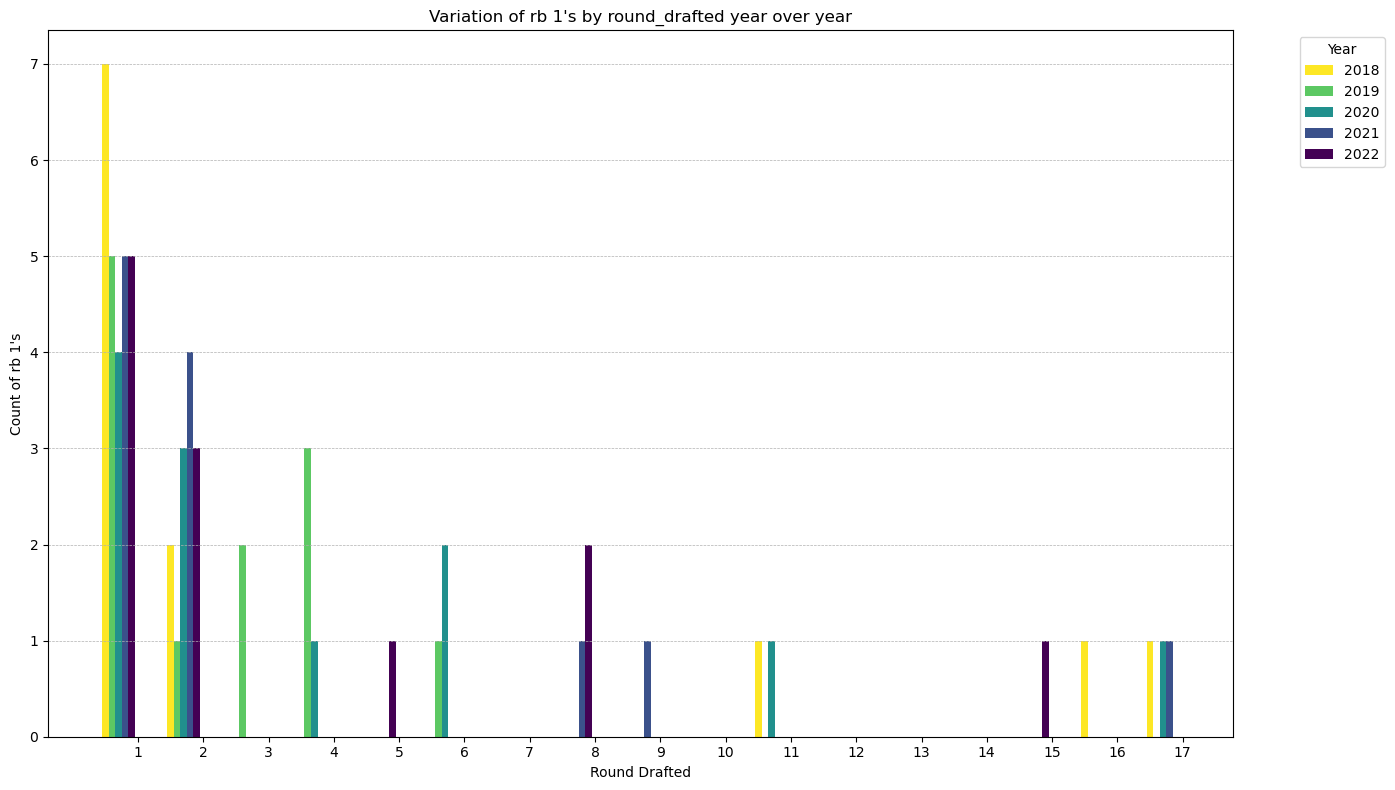

In [38]:
top_performers_by_round(df, 'rb')

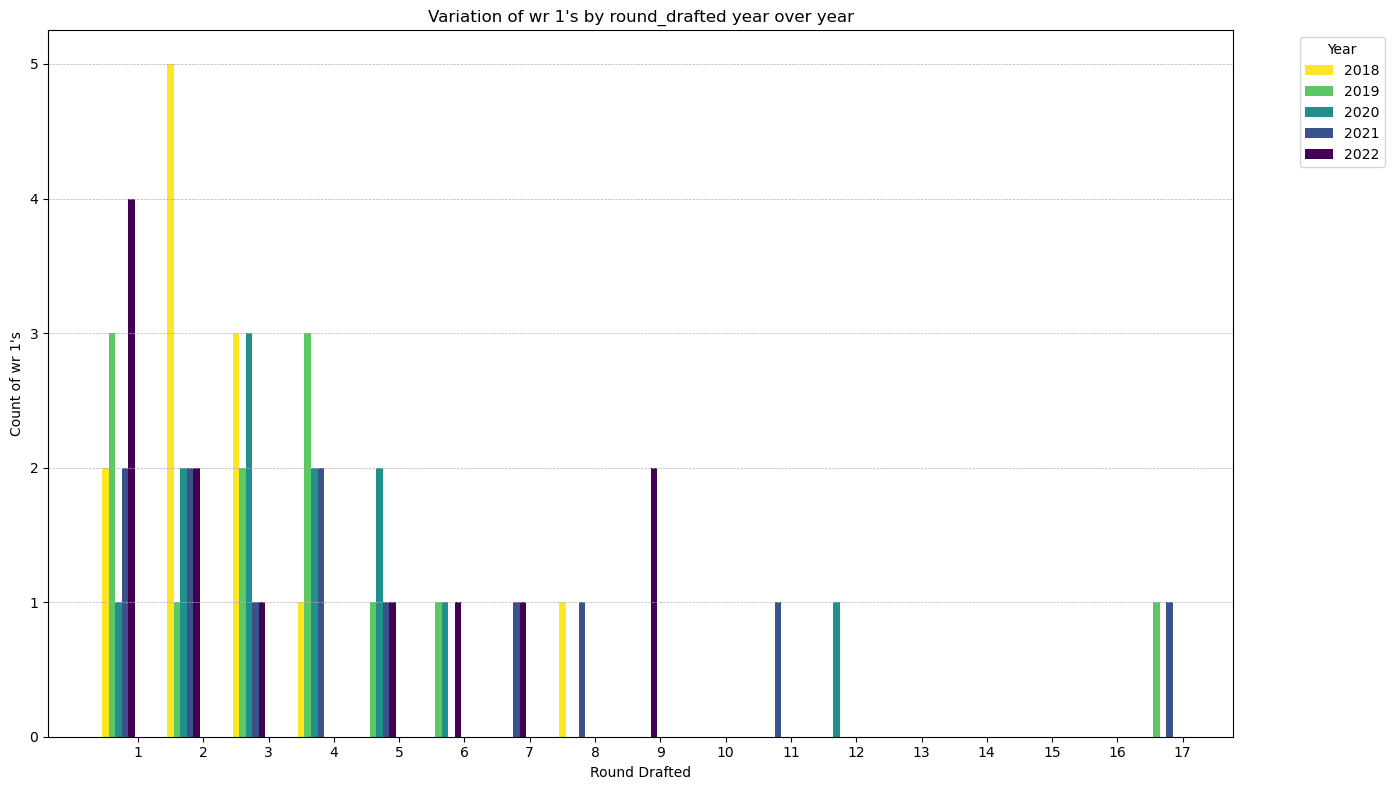

In [39]:
top_performers_by_round(df, 'wr')

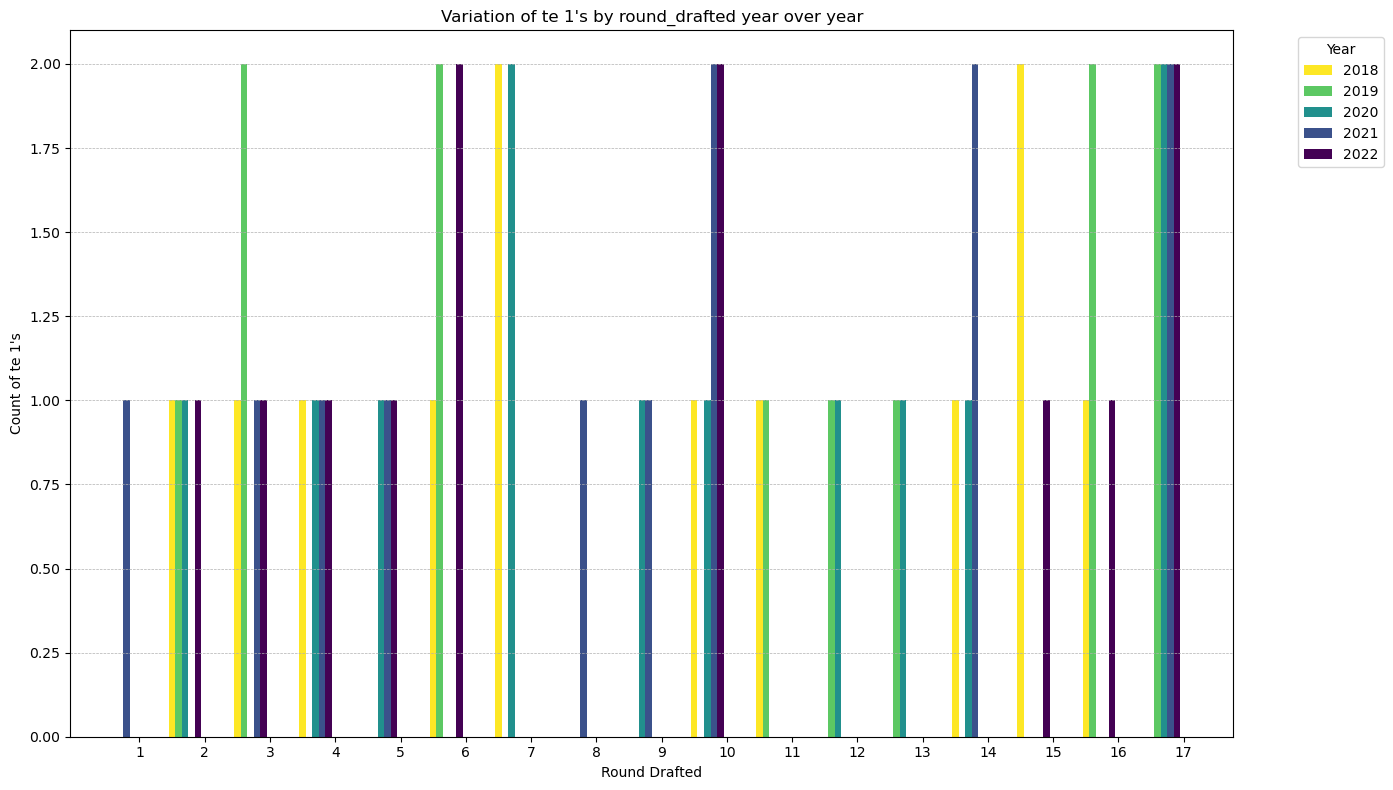

In [40]:
top_performers_by_round(df, 'te')

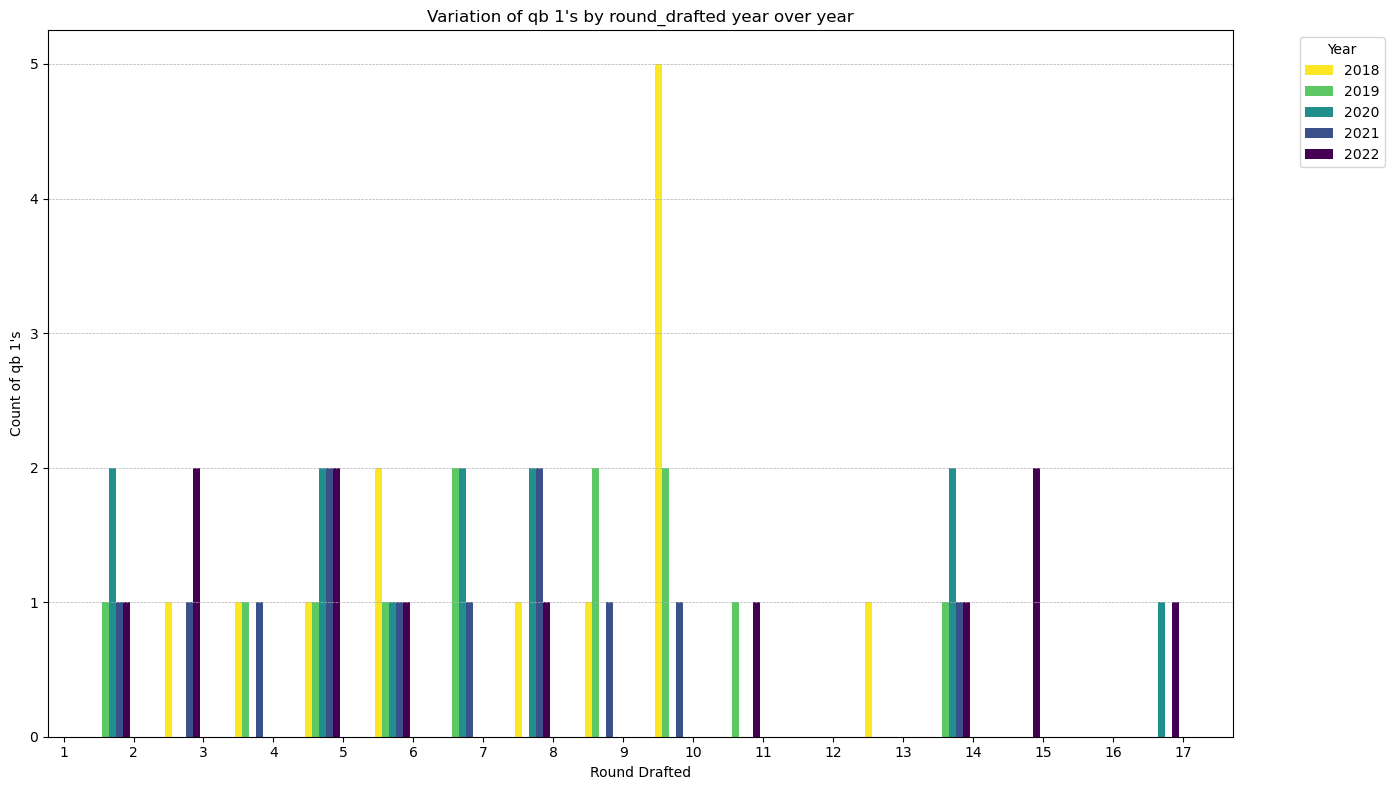

In [41]:
top_performers_by_round(df, 'qb')